## LSTM Variational Autoencoder

LSTM автоэнкодер с *variational* архитектурой в большей степени предотвращает переобучение, благодаря тому, что на латентном уровне есть шум, поэтому он так и называется. Обычный автоэнкодер может слишком хорошо запомнить рабочее нормальное состояние системы, и в случае даже малейшего отклонения сигнализировать об обнаружении аномалии. 

В VAE есть разброс за счет нормального стандартного отклонения. То есть мы хотим не просто как-то закодировать входное окно, а закодировать так, чтобы латентные вектора были распределены стандартно нормально. Тогда чем дальше от среднего закодированный вектор, тем наиболее вероятно, что декодер хуже восстановит исходное окно, а значит модель в целом определит его как аномальное. 

Таким образом, все что распределено около среднего в $N(\mu=0, \sigma=1)$ в интервале $[-2\sigma, 2\sigma]$ будет с наибольшей вероятностью восстановлено, и чем дальше от границ интервала тем менее вероятно. В остальном VAE все тот же автоэнкодер.

Как заставить получать латентные вектора из стандартного нормального распределения? Необходимо помимо обычного MSE между реальным и предсказанным окном добавить штраф за параметры распределения. Например, с помощью расстояния 
Кульбака-Лейблера.

Более формально, пусть на выходе из энкодера есть вектора $h$ и $c$. Для простоты будем рассматривать только один из них, для второго все аналогично. Тогда скажем, что $z_{\mu} = Dense(h)$, $z_{\sigma} = Dense(h)$, делаем два разных денса, чтобы для среднего и отклонения были разные веса. Затем вычисляем латентный вектор $z = z_{\mu} + z_{\sigma} \epsilon$, где $\epsilon \in N(\hat z_{\mu}, \hat z_{\sigma})$ и передаем его в декодер. В лосс добавляем штраф между $\hat z_{\mu}, \hat z_{\sigma}$ и $z_{\mu}, z_{\sigma}$.Таким образом, в процессе обучения вектора будут все лучше будут попадать в распределение $N(\hat z_{\mu}, \hat z_{\sigma})$. Параметры такого распределения определяются до начала обучения и могут инициализироваться как угодно, например $0$ и $1$ соответственно.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import f1_score, far, mar

from keras.layers import Input, LSTM, Lambda, RepeatVector, Dense, TimeDistributed
from keras.models import Model

### Seed fixation

In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

### Load data

In [7]:
df = pd.read_csv("data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


### Make model & predictor

In [3]:
from keras import backend
import tensorflow as tf
from tensorflow.keras import losses

In [4]:
class LSTM_VAE:
    def __init__(self, activation='relu', optimizer='adam', 
                 loss=losses.MeanSquaredError, hat_mean=0, hat_sigma=1):
        
        self.activation = activation
        self.optimizer = optimizer
        if isinstance(loss, losses.Loss):
            raise TypeError("Loss should be keras class")
        self.loss = loss()
        
        self.hat_mean = hat_mean
        self.hat_sigma = hat_sigma
        
    def fit(self, train_windows, batch_size=32, epochs=2):
        windows_count, time_steps, n_features = train_windows.shape
        
        encoder_input = Input(shape = (None, n_features))
        encoder_output = LSTM(units=128, return_state = False, 
                              return_sequences = False)(encoder_input)
        
        latent_dim = 64
        z_mean = Dense(units=latent_dim, name="z_mean")(encoder_output)
        z_sigma = Dense(units=latent_dim, name="z_sigma")(encoder_output)
        
        def sampling(args):
            z_mean, z_sigma = args
            epsilon = backend.random_normal(
                shape=(latent_dim, ), mean=self.hat_mean, stddev=self.hat_sigma)
            
            return z_mean + z_sigma * epsilon
            
        
        z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_sigma])
        z_repeat = RepeatVector(time_steps)(z)
        
        decoder_lstm = LSTM(units=128, return_state = False, 
                            return_sequences = True)(z_repeat)
        
        decoder_output = TimeDistributed(Dense(n_features))(decoder_lstm)
        
        self.model = Model(encoder_input, decoder_output)
        
        def loss_function(x, x_reconstructed):
            reconstructed_loss = self.loss(x, x_reconstructed)
            kl_loss = -0.5 * backend.mean(
                self.hat_sigma + z_sigma - backend.square(z_mean) - backend.exp(z_sigma))

            return reconstructed_loss + kl_loss
        
        self.model.add_loss(loss_function(encoder_input, decoder_output))
        
        self.model.compile(optimizer=self.optimizer, loss=None)
        history = self.model.fit(train_windows, train_windows, 
                                 epochs=epochs, batch_size=batch_size)
        return self
    
    def predict(self, test_windows):
        return self.model.predict(test_windows)

In [5]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [6]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10
    Q = 0.99
    
conf = Config

class LSTM_VAE_Predictor(Predictor):
    def make_prediction(self, df):
        first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
        df = df.drop(['anomaly','changepoint'], axis=1)
        conf.train_size = first_anomaly_idx
        ss = StandardScaler()
        
        x_train = np.array(ss.fit_transform(df[:conf.train_size]))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_VAE(optimizer=optimizer, loss=losses.MeanSquaredError)
        model.fit(x_train, epochs=conf.epochs, batch_size=conf.batch_size)

        x_test = np.array(ss.transform(df))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))  
        health_r = r[:conf.train_size]

        UCL = health_r[: len(health_r) - conf.TIME_STEPS + 1].quantile(conf.Q)
        
        anomalous_data = r > UCL
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS, len(x_test) - conf.TIME_STEPS + 1):
            if (anomalous_data[data_idx - conf.TIME_STEPS : data_idx]).astype(int).sum() >= conf.TIME_STEPS * 0.8:
                anomalous_data_indices.append(data_idx - conf.TIME_STEPS)
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

In [142]:
prediction = LSTM_VAE_Predictor().make_prediction(df)

Epoch 1/10
53/53 [==============================] - 11s 101ms/step - loss: 0.8117
Epoch 2/10
53/53 [==============================] - 5s 101ms/step - loss: 0.7522
Epoch 3/10
53/53 [==============================] - 5s 102ms/step - loss: 0.7368
Epoch 4/10
53/53 [==============================] - 7s 130ms/step - loss: 0.7245
Epoch 5/10
53/53 [==============================] - 7s 125ms/step - loss: 0.7139
Epoch 6/10
53/53 [==============================] - 7s 122ms/step - loss: 0.7012
Epoch 7/10
53/53 [==============================] - 5s 104ms/step - loss: 0.6918
Epoch 8/10
53/53 [==============================] - 5s 94ms/step - loss: 0.6791
Epoch 9/10
53/53 [==============================] - 5s 87ms/step - loss: 0.6700
Epoch 10/10
53/53 [==============================] - 4s 82ms/step - loss: 0.6624


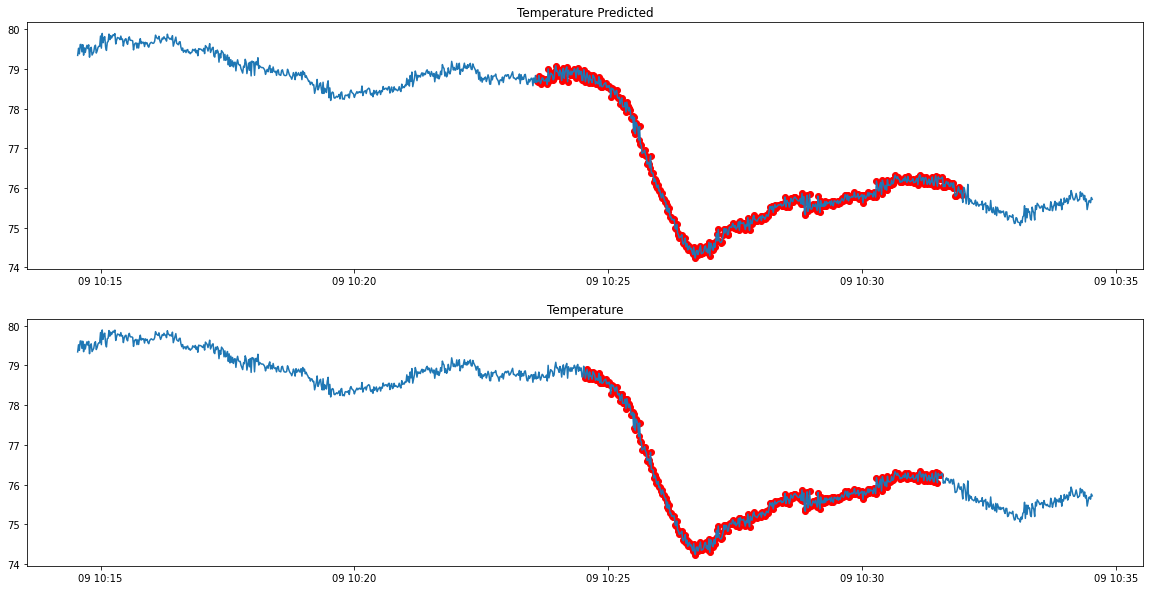

In [143]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [144]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.9103291713961408
FAR = 0.10589812332439678
MAR = 0.0


### Применение метода ко всем датасетам

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 124ms/step - loss: 0.9178
Epoch 2/10
53/53 [==============================] - 5s 86ms/step - loss: 0.8183
Epoch 3/10
53/53 [==============================] - 5s 91ms/step - loss: 0.7880
Epoch 4/10
53/53 [==============================] - 5s 90ms/step - loss: 0.7735
Epoch 5/10
53/53 [==============================] - 5s 85ms/step - loss: 0.7612
Epoch 6/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7523
Epoch 7/10
53/53 [==============================] - 5s 85ms/step - loss: 0.7421
Epoch 8/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7343
Epoch 9/10
53/53 [==============================] - 5s 89ms/step - loss: 0.7257
Epoch 10/10
53/53 [==============================] - 6s 122ms/step - loss: 0.7166
Epoch 1/10
53/53 [==============================] - 9s 89ms/step - loss: 0.8275
Epoch 2/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7664
Epoch 3/10
53/53 [==================

53/53 [==============================] - 4s 79ms/step - loss: 0.7640
Epoch 3/10
53/53 [==============================] - 4s 78ms/step - loss: 0.7407
Epoch 4/10
53/53 [==============================] - 4s 78ms/step - loss: 0.7251
Epoch 5/10
53/53 [==============================] - 4s 78ms/step - loss: 0.7058
Epoch 6/10
53/53 [==============================] - 4s 80ms/step - loss: 0.6948
Epoch 7/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6859
Epoch 8/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6803
Epoch 9/10
53/53 [==============================] - 4s 78ms/step - loss: 0.6768
Epoch 10/10
53/53 [==============================] - 4s 78ms/step - loss: 0.6714
Epoch 1/10
52/52 [==============================] - 7s 71ms/step - loss: 0.8059
Epoch 2/10
52/52 [==============================] - 4s 71ms/step - loss: 0.7530
Epoch 3/10
52/52 [==============================] - 4s 70ms/step - loss: 0.7301
Epoch 4/10
52/52 [==============================] 

IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 9s 77ms/step - loss: 0.8532
Epoch 2/10
52/52 [==============================] - 6s 114ms/step - loss: 0.7974
Epoch 3/10
52/52 [==============================] - 9s 180ms/step - loss: 0.7736
Epoch 4/10
52/52 [==============================] - 5s 94ms/step - loss: 0.7603
Epoch 5/10
52/52 [==============================] - 5s 88ms/step - loss: 0.7454
Epoch 6/10
52/52 [==============================] - 4s 76ms/step - loss: 0.7328
Epoch 7/10
52/52 [==============================] - 4s 76ms/step - loss: 0.7185
Epoch 8/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7073
Epoch 9/10
52/52 [==============================] - 4s 76ms/step - loss: 0.7012
Epoch 10/10
52/52 [==============================] - 4s 77ms/step - loss: 0.6962
Epoch 1/10
52/52 [==============================] - 8s 76ms/step - loss: 0.8482
Epoch 2/10
52/52 [==============================] - 4s 76ms/step - loss: 0.7975
Epoch 3/10
52/52 [===================

IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 97ms/step - loss: 0.8567
Epoch 2/10
53/53 [==============================] - 5s 99ms/step - loss: 0.8109
Epoch 3/10
53/53 [==============================] - 5s 93ms/step - loss: 0.7866
Epoch 4/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7691
Epoch 5/10
53/53 [==============================] - 7s 134ms/step - loss: 0.7654
Epoch 6/10
53/53 [==============================] - 14s 261ms/step - loss: 0.7479
Epoch 7/10
53/53 [==============================] - 9s 161ms/step - loss: 0.7415
Epoch 8/10
53/53 [==============================] - 4s 77ms/step - loss: 0.7366
Epoch 9/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7314
Epoch 10/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7256
F1 = 0.9251282051282051

FAR = 0.09878213802435724

MAR = 0.0

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 78ms/step - loss: 0.8274
Epoch 2/10
53/53 [==============================] - 4s 77ms/step - loss: 0.7528
Epoch 3/10
53/53 [==============================] - 4s 77ms/step - loss: 0.7344
Epoch 4/10
53/53 [==============================] - 4s 78ms/step - loss: 0.7210
Epoch 5/10
53/53 [==============================] - 4s 78ms/step - loss: 0.7069
Epoch 6/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6975
Epoch 7/10
53/53 [==============================] - 5s 89ms/step - loss: 0.6852
Epoch 8/10
53/53 [==============================] - 4s 78ms/step - loss: 0.6777
Epoch 9/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6733
Epoch 10/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6674
F1 = 0.909297052154195

FAR = 0.10767160161507403

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 77ms/step - loss: 0.8888
Epoch 2/10
53/53 [==============================] - 4s 77ms/step - loss: 0.8135
Epoch 3/10
53/53 [==============================] - 5s 102ms/step - loss: 0.7697
Epoch 4/10
53/53 [==============================] - 4s 85ms/step - loss: 0.7444
Epoch 5/10
53/53 [==============================] - 4s 77ms/step - loss: 0.7056
Epoch 6/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6769
Epoch 7/10
53/53 [==============================] - 4s 78ms/step - loss: 0.6659
Epoch 8/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6612
Epoch 9/10
53/53 [==============================] - 5s 103ms/step - loss: 0.6547
Epoch 10/10
53/53 [==============================] - 5s 100ms/step - loss: 0.6437
F1 = 0.9070796460176991

FAR = 0.11275167785234899

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 9s 92ms/step - loss: 0.8189
Epoch 2/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7530
Epoch 3/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7315
Epoch 4/10
52/52 [==============================] - 5s 87ms/step - loss: 0.7161
Epoch 5/10
52/52 [==============================] - 5s 90ms/step - loss: 0.6966
Epoch 6/10
52/52 [==============================] - 5s 89ms/step - loss: 0.6800
Epoch 7/10
52/52 [==============================] - 5s 91ms/step - loss: 0.6703
Epoch 8/10
52/52 [==============================] - 4s 86ms/step - loss: 0.6626
Epoch 9/10
52/52 [==============================] - 5s 91ms/step - loss: 0.6578
Epoch 10/10
52/52 [==============================] - 4s 84ms/step - loss: 0.6524
F1 = 0.946031746031746

FAR = 0.03112313937753721

MAR = 0.03559870550161812

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
45/45 [==============================] - 7s 77ms/step - loss: 0.7301
Epoch 2/10
45/45 [==============================] - 3s 77ms/step - loss: 0.6414
Epoch 3/10
45/45 [==============================] - 3s 76ms/step - loss: 0.6216
Epoch 4/10
45/45 [==============================] - 3s 76ms/step - loss: 0.6066
Epoch 5/10
45/45 [==============================] - 3s 77ms/step - loss: 0.5853
Epoch 6/10
45/45 [==============================] - 3s 77ms/step - loss: 0.5736
Epoch 7/10
45/45 [==============================] - 3s 77ms/step - loss: 0.5594
Epoch 8/10
45/45 [==============================] - 3s 76ms/step - loss: 0.5499
Epoch 9/10
45/45 [==============================] - 3s 77ms/step - loss: 0.5437
Epoch 10/10
45/45 [==============================] - 3s 77ms/step - loss: 0.5373
F1 = 0.1320754716981132

FAR = 0.0486322188449848

MAR = 0.9207547169811321

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 8s 77ms/step - loss: 0.8387
Epoch 2/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7833
Epoch 3/10
52/52 [==============================] - 4s 79ms/step - loss: 0.7689
Epoch 4/10
52/52 [==============================] - 4s 79ms/step - loss: 0.7589
Epoch 5/10
52/52 [==============================] - 4s 80ms/step - loss: 0.7526
Epoch 6/10
52/52 [==============================] - 4s 79ms/step - loss: 0.7460
Epoch 7/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7409
Epoch 8/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7352
Epoch 9/10
52/52 [==============================] - 4s 77ms/step - loss: 0.7314
Epoch 10/10
52/52 [==============================] - 5s 91ms/step - loss: 0.7274
F1 = 0.9159953970080552

FAR = 0.09878213802435724

MAR = 0.0

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
51/51 [==============================] - 9s 77ms/step - loss: 0.7734
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 0.7053
Epoch 3/10
51/51 [==============================] - 4s 78ms/step - loss: 0.6936
Epoch 4/10
51/51 [==============================] - 5s 91ms/step - loss: 0.6860
Epoch 5/10
51/51 [==============================] - 4s 84ms/step - loss: 0.6782
Epoch 6/10
51/51 [==============================] - 4s 81ms/step - loss: 0.6737
Epoch 7/10
51/51 [==============================] - 4s 78ms/step - loss: 0.6685
Epoch 8/10
51/51 [==============================] - 4s 76ms/step - loss: 0.6643
Epoch 9/10
51/51 [==============================] - 4s 76ms/step - loss: 0.6588
Epoch 10/10
51/51 [==============================] - 4s 76ms/step - loss: 0.6545
F1 = 0.3053435114503817

FAR = 0.06104129263913824

MAR = 0.7872340425531915

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 77ms/step - loss: 0.8609
Epoch 2/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7912
Epoch 3/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7653
Epoch 4/10
53/53 [==============================] - 4s 77ms/step - loss: 0.7387
Epoch 5/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7203
Epoch 6/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7089
Epoch 7/10
53/53 [==============================] - 4s 76ms/step - loss: 0.7033
Epoch 8/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6976
Epoch 9/10
53/53 [==============================] - 4s 76ms/step - loss: 0.6894
Epoch 10/10
53/53 [==============================] - 4s 76ms/step - loss: 0.6835
F1 = 0.895483870967742

FAR = 0.10901749663526245

MAR = 0.0

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 94ms/step - loss: 0.8635
Epoch 2/10
53/53 [==============================] - 5s 86ms/step - loss: 0.8011
Epoch 3/10
53/53 [==============================] - 5s 88ms/step - loss: 0.7800
Epoch 4/10
53/53 [==============================] - 5s 88ms/step - loss: 0.7622
Epoch 5/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7498
Epoch 6/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7342
Epoch 7/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7247
Epoch 8/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7170
Epoch 9/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7100
Epoch 10/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7065
F1 = 0.9413654618473896

FAR = 0.09851551956815115

MAR = 0.0

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 86ms/step - loss: 0.9029
Epoch 2/10
53/53 [==============================] - 5s 86ms/step - loss: 0.8360
Epoch 3/10
53/53 [==============================] - 5s 89ms/step - loss: 0.8089
Epoch 4/10
53/53 [==============================] - 5s 87ms/step - loss: 0.7873
Epoch 5/10
53/53 [==============================] - 5s 87ms/step - loss: 0.7705
Epoch 6/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7587
Epoch 7/10
53/53 [==============================] - 5s 87ms/step - loss: 0.7511
Epoch 8/10
53/53 [==============================] - 5s 87ms/step - loss: 0.7464
Epoch 9/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7421
Epoch 10/10
53/53 [==============================] - 5s 86ms/step - loss: 0.7366
F1 = 0.6726943942133815

FAR = 0.1077943615257048

MAR = 0.3841059602649007

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
75/75 [==============================] - 11s 86ms/step - loss: 0.7869
Epoch 2/10
75/75 [==============================] - 6s 86ms/step - loss: 0.7194
Epoch 3/10
75/75 [==============================] - 7s 86ms/step - loss: 0.7057
Epoch 4/10
75/75 [==============================] - 7s 89ms/step - loss: 0.6978
Epoch 5/10
75/75 [==============================] - 8s 102ms/step - loss: 0.6903
Epoch 6/10
75/75 [==============================] - 7s 88ms/step - loss: 0.6807
Epoch 7/10
75/75 [==============================] - 7s 98ms/step - loss: 0.6724
Epoch 8/10
75/75 [==============================] - 6s 79ms/step - loss: 0.6674
Epoch 9/10
75/75 [==============================] - 7s 88ms/step - loss: 0.6626
Epoch 10/10
75/75 [==============================] - 7s 96ms/step - loss: 0.6576
F1 = 0.7307692307692307

FAR = 0.04271356783919598

MAR = 0.37468354430379747

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 9s 87ms/step - loss: 0.8822
Epoch 2/10
53/53 [==============================] - 5s 87ms/step - loss: 0.8119
Epoch 3/10
53/53 [==============================] - 5s 91ms/step - loss: 0.7662
Epoch 4/10
53/53 [==============================] - 5s 89ms/step - loss: 0.7432
Epoch 5/10
53/53 [==============================] - 5s 103ms/step - loss: 0.7323
Epoch 6/10
53/53 [==============================] - 6s 106ms/step - loss: 0.7267
Epoch 7/10
53/53 [==============================] - 6s 115ms/step - loss: 0.7216
Epoch 8/10
53/53 [==============================] - 5s 97ms/step - loss: 0.7149
Epoch 9/10
53/53 [==============================] - 7s 123ms/step - loss: 0.7107
Epoch 10/10
53/53 [==============================] - 5s 88ms/step - loss: 0.7068
F1 = 0.9064261555806088

FAR = 0.11140939597315436

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 10s 106ms/step - loss: 0.8653
Epoch 2/10
53/53 [==============================] - 5s 91ms/step - loss: 0.7956
Epoch 3/10
53/53 [==============================] - 5s 87ms/step - loss: 0.7683
Epoch 4/10
53/53 [==============================] - 5s 87ms/step - loss: 0.7404
Epoch 5/10
53/53 [==============================] - 5s 90ms/step - loss: 0.7193
Epoch 6/10
53/53 [==============================] - 5s 98ms/step - loss: 0.7007
Epoch 7/10
53/53 [==============================] - 5s 89ms/step - loss: 0.6897
Epoch 8/10
53/53 [==============================] - 5s 89ms/step - loss: 0.6800
Epoch 9/10
53/53 [==============================] - 5s 90ms/step - loss: 0.6725
Epoch 10/10
53/53 [==============================] - 5s 89ms/step - loss: 0.6678
F1 = 0.9076576576576577

FAR = 0.11021505376344086

MAR = 0.0

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
6/6 [==============================] - 4s 88ms/step - loss: 0.9415
Epoch 2/10
6/6 [==============================] - 1s 105ms/step - loss: 0.9017
Epoch 3/10
6/6 [==============================] - 1s 87ms/step - loss: 0.8927
Epoch 4/10
6/6 [==============================] - 1s 87ms/step - loss: 0.8855
Epoch 5/10
6/6 [==============================] - 1s 87ms/step - loss: 0.8761
Epoch 6/10
6/6 [==============================] - 1s 110ms/step - loss: 0.8675
Epoch 7/10
6/6 [==============================] - 1s 86ms/step - loss: 0.8581
Epoch 8/10
6/6 [==============================] - 1s 111ms/step - loss: 0.8337
Epoch 9/10
6/6 [==============================] - 1s 86ms/step - loss: 0.8124
Epoch 10/10
6/6 [==============================] - 1s 86ms/step - loss: 0.7988
F1 = 0.7925696594427245

FAR = 0.5075757575757576

MAR = 0.0

CPU times: user 1h 19min 25s, sys: 4min 48s, total: 1h 24min 13s
Wall time: 32min 2s


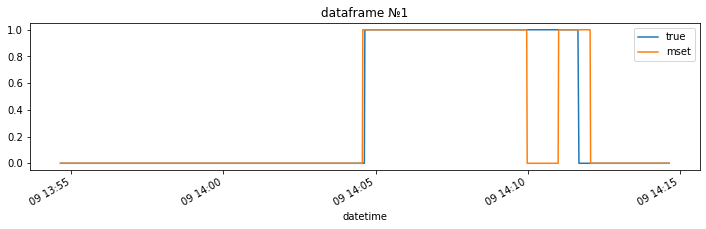

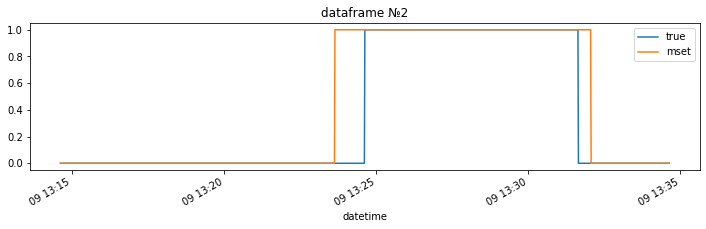

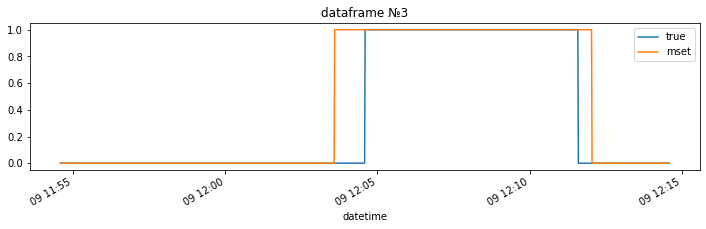

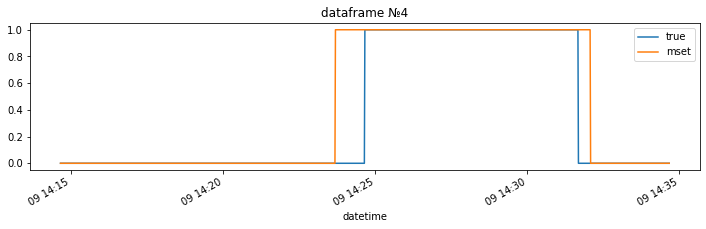

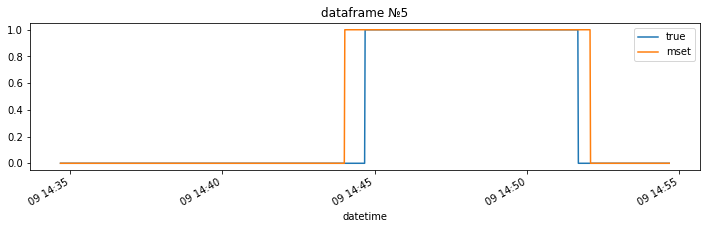

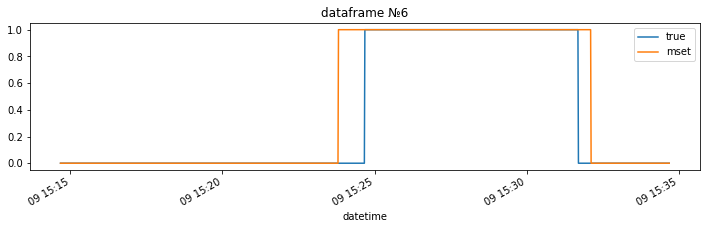

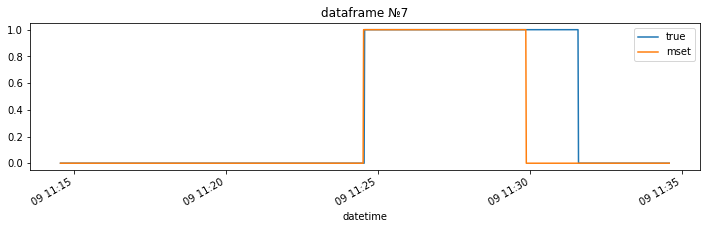

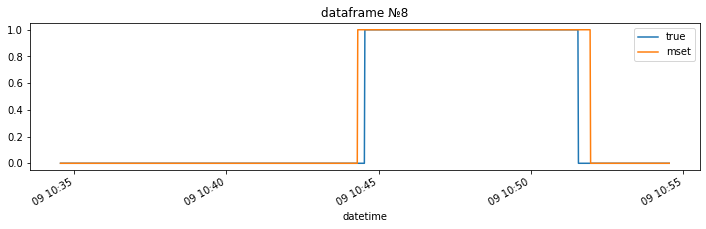

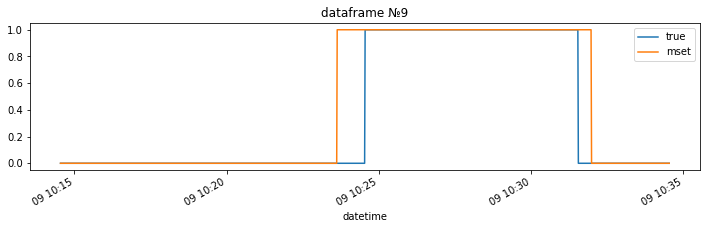

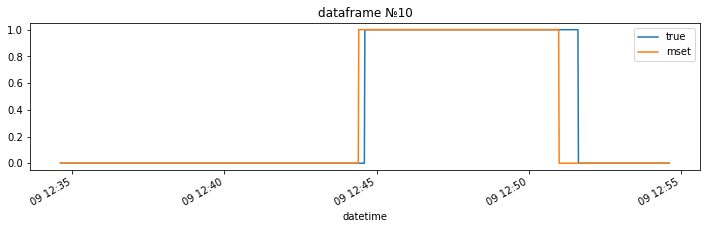

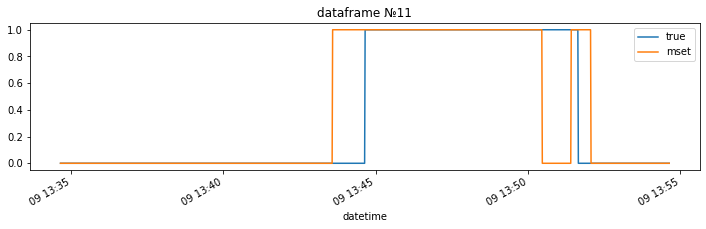

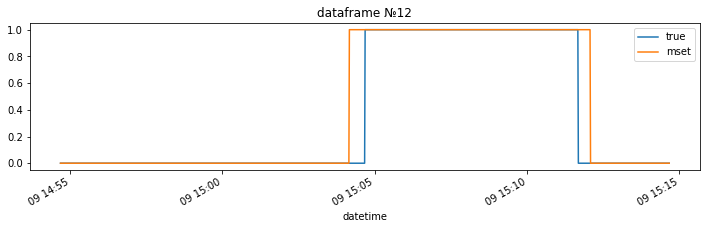

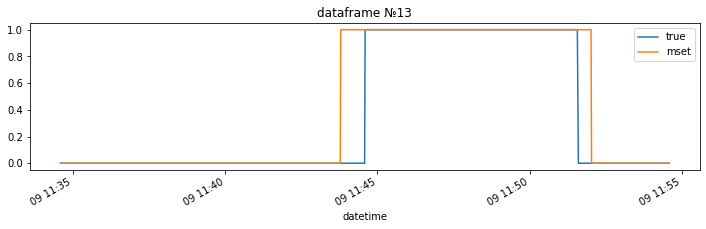

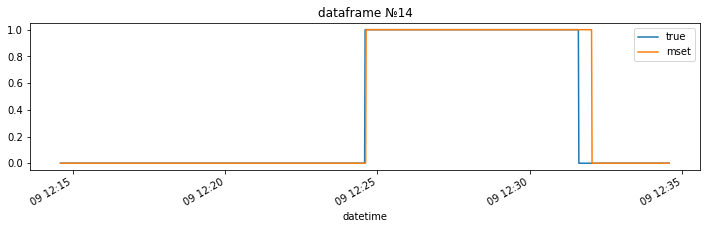

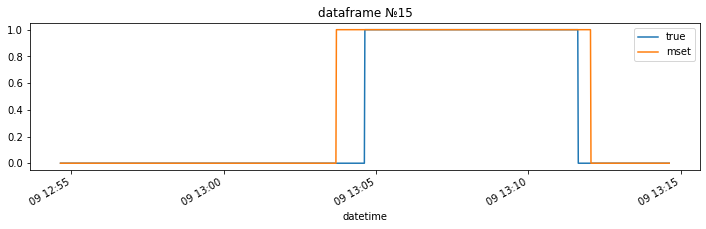

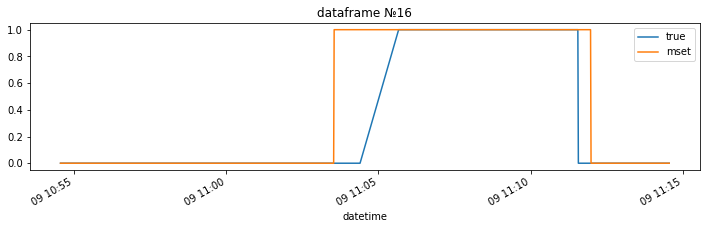

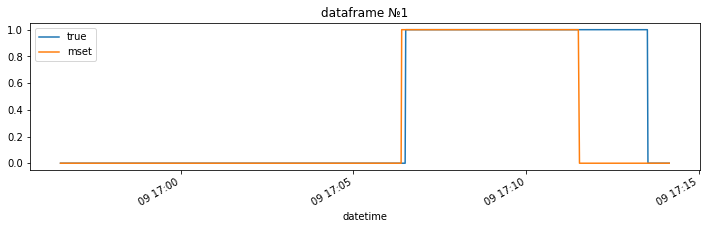

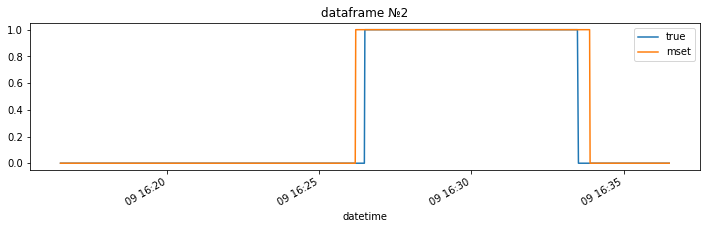

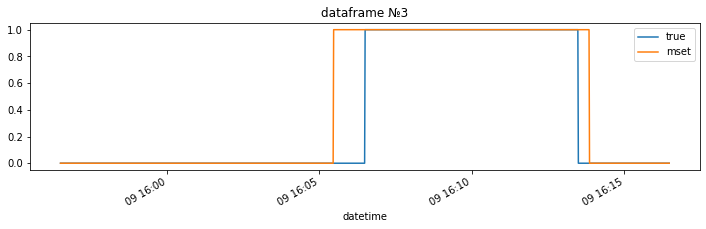

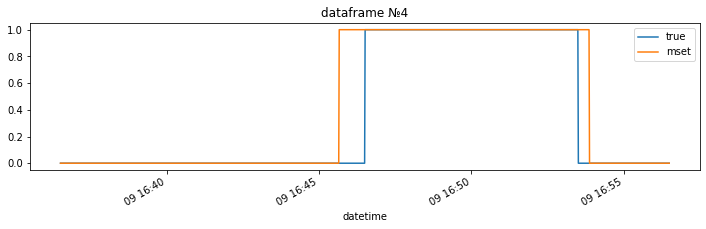

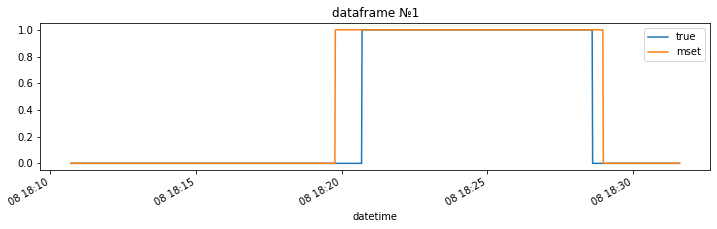

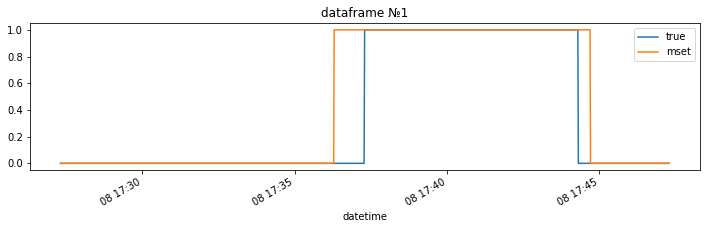

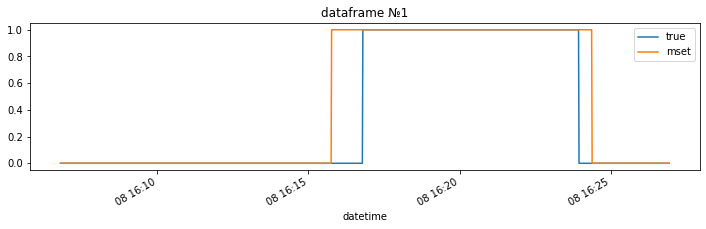

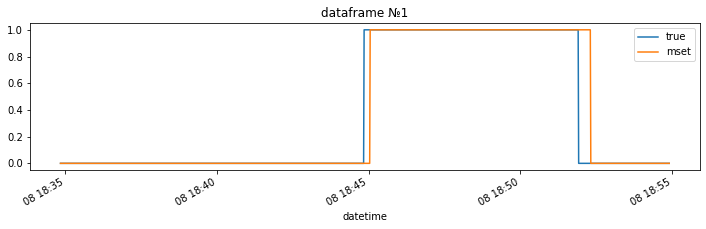

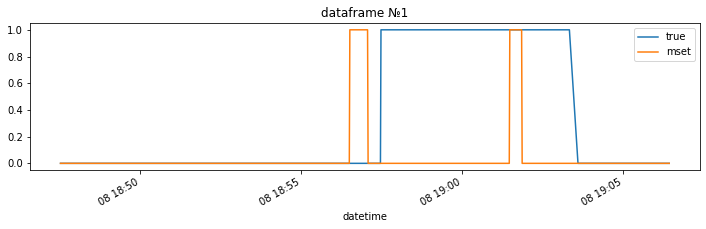

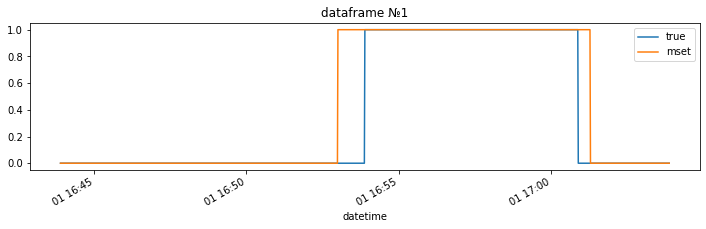

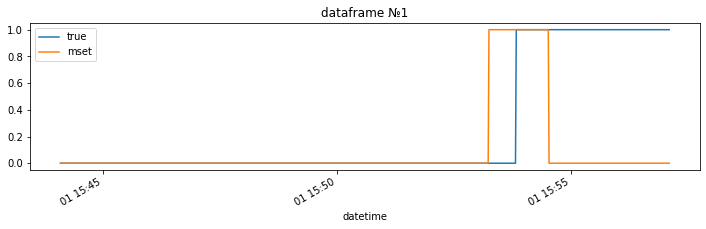

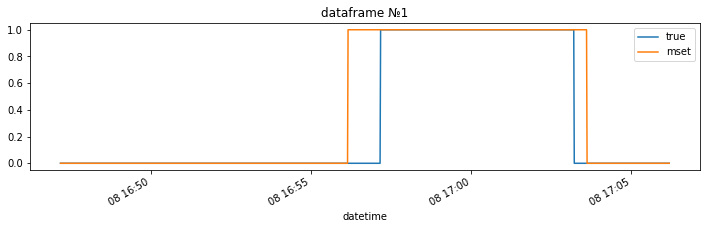

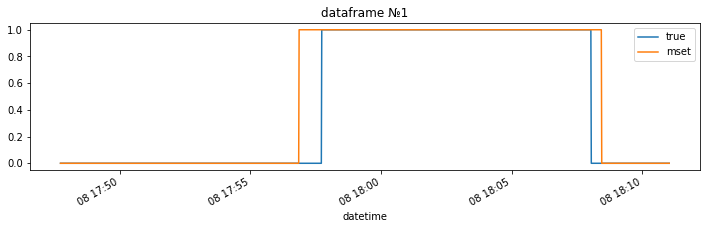

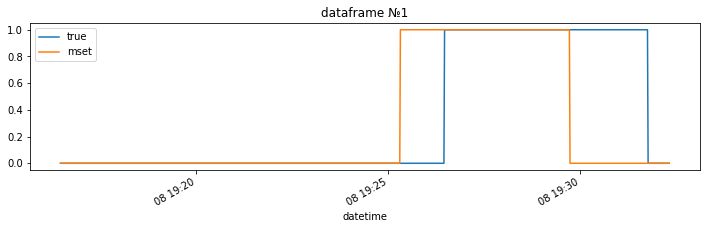

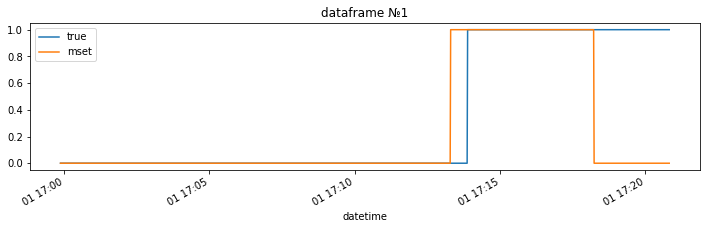

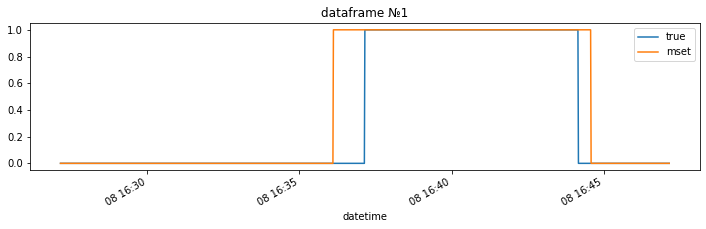

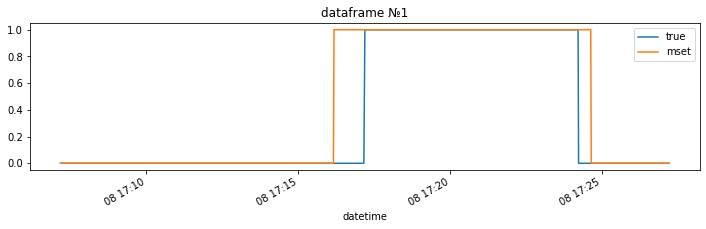

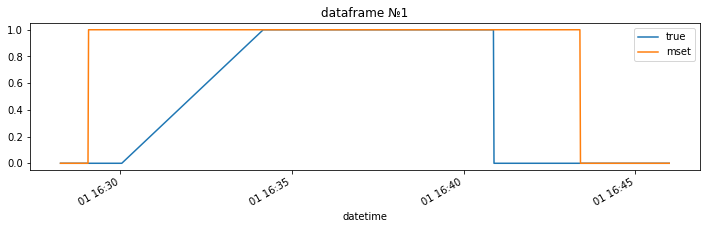

In [8]:
%%time
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = LSTM_VAE_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [9]:
from utils.metrics import f1_score, far, mar

pred_outlier = pd.concat([pd.concat(p.all_predictions[i]) 
                          for i in range(len(p.all_predictions))])

list_of_all_df = []
for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            list_of_all_df.append(pd.concat([df.anomaly for df in [df, ]]))
    else:
        list_of_all_df.append(pd.concat([df.anomaly for df in list_of_df]))

true_outlier = pd.concat(list_of_all_df)

f1 = f1_score(true_outlier, pred_outlier)
far_score = far(true_outlier, pred_outlier)
mar_score = mar(true_outlier, pred_outlier)

metrics["all"] = (f1, far_score, mar_score)

In [10]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.91 | 0.9 | 0.93 | 0.91 | 0.91 | 0.95 | 0.13 | 0.92 | 0.31 | 0.9 | 0.94 | 0.67 | 0.73 | 0.91 | 0.91 | 0.79 | 0.88
FAR |0.08 | 0.07 | 0.1 | 0.11 | 0.11 | 0.03 | 0.05 | 0.1 | 0.06 | 0.11 | 0.1 | 0.11 | 0.04 | 0.11 | 0.11 | 0.51 | 0.09
MAR |0.04 | 0.07 | 0.0 | 0.0 | 0.0 | 0.04 | 0.92 | 0.0 | 0.79 | 0.0 | 0.0 | 0.38 | 0.37 | 0.0 | 0.0 | 0.0 | 0.08